# 1. Setup Mario Environment

In [12]:
# install mario environment and nespy
# !pip install gym_super_mario_bros==7.3.0 nes_py

Name: gym
Version: 0.26.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.dev/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages
Requires: cloudpickle, gym-notices, numpy
Required-by: nes-py


In [1]:
# import the game
import gym_super_mario_bros
# import the Jobpad wrapper
from nes_py.wrappers import JoypadSpace
# import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [4]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
# reset the game
# state = env.reset() 

# Access the game screen image from the tuple
# screen_image = state[0]

# Get the shape of the image
# screen_image.shape

In [ ]:
# restart or not
done = True
# Loop through each frame in the game
for step in range(5000):
    if done:
        # Start the game
        env.reset()
    # Do random actions
    state, reward, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    # display the game
    env.render()

# Close the game
env.close()

In [ ]:
# reset state before using
# state = env.reset()

# 0 is frames for the move:
# env.step(1)[0]
# 1 is reward for that move:
# env.step(1)[1]
# 2 is for whether you are dead(True) or not(False):
# env.step(1)[2]
# 3 is for whether game is over or not:
# env.step(1)[3]
# 4 is for more information
# env.step(1)[4]

# 2. Preprocess Environment

In [ ]:
# install stable baselines3
# !pip install stable-baselines3[extra]

In [2]:
# import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation

# import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [4]:
from nes_py.wrappers import JoypadSpace
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0',apply_api_compatibility=True,render_mode="human" )
# Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Color to GrayScale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap environment inside the Dummmy environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

if color, its pixels would be 240x256x3 = 184320

if grayscale, its pixels would be 240x256x1 = 61440

In [7]:
# let's see how it looks when mario jumps
done = True
# Loop through each frame in the game
for step in range(10):
    if done:
        # Start the game
        state = env.reset()
    # Do random actions
    state, reward, done, info = env.step([5])

In [8]:
state.shape

(1, 240, 256, 4)

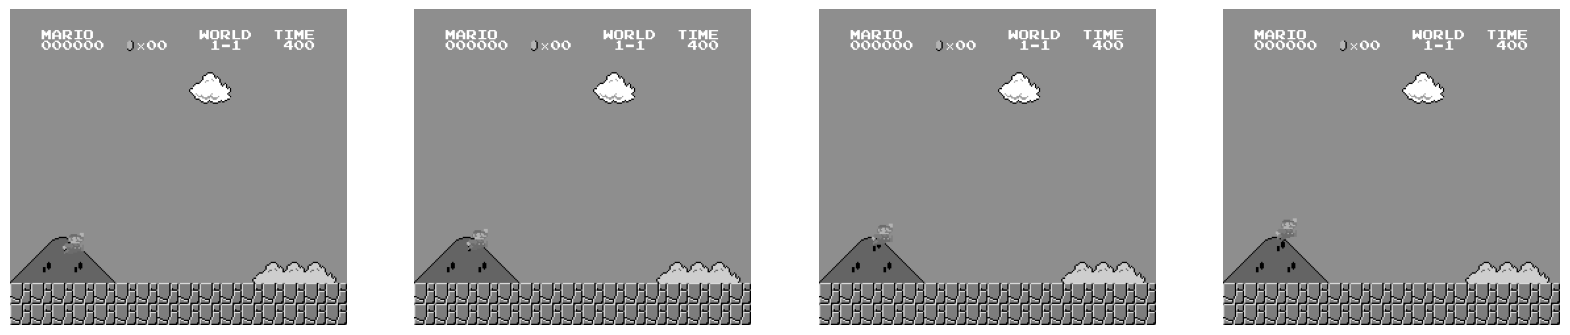

In [9]:
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0][:, :, idx], cmap='gray')  # Specify the colormap as 'gray'
    plt.axis('off')  # Turn off axis labels

plt.show()


# 3. Train the RL Model

In [5]:
# Import os for file path management
import os 
# Import PPO(Proximal Policy Optimization) algorithm
from stable_baselines3 import PPO

In [6]:
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [7]:
# Save trained models and logs 
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [8]:
# Setup Callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [9]:
# AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [10]:
# Training the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=4000000, callback=callback)

C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Logging to ./logs/PPO_7


C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 45  |
|    iterations      | 1   |
|    time_elapsed    | 11  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 9             |
|    iterations           | 2             |
|    time_elapsed         | 112           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.1700864e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00818       |
|    learning_rate        | 1e-06         |
|    loss                 | 177           |
|    n_updates            | 10            |
|    policy_gradient_loss | -4.39e-05     |
|    value_loss           | 432           |
-------------------------------------------
-----

-------------------------------------------
| time/                   |               |
|    fps                  | 4             |
|    iterations           | 13            |
|    time_elapsed         | 1371          |
|    total_timesteps      | 6656          |
| train/                  |               |
|    approx_kl            | 1.5722704e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.000313     |
|    learning_rate        | 1e-06         |
|    loss                 | 0.0746        |
|    n_updates            | 120           |
|    policy_gradient_loss | -0.00022      |
|    value_loss           | 0.204         |
-------------------------------------------


KeyboardInterrupt: 

# 4. Test it Out

In [6]:
model = PPO.load('./train/best_model_4000000', env=env)

C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


Wrapping the env in a VecTransposeImage.


In [ ]:
# Start the game
state = env.reset()
# Loop through the game
while True:
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
C:\Users\91889\OneDrive\Desktop\Mario AI\marioenv\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [8]:
env.close()